In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import zipfile
import os

####**Extract images and convert to gray scale**

In [ ]:
zip_path = "/content/Q NO 02 Images.zip"
extract_folder = "/content/dataset"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_folder)

os.listdir(extract_folder)

['Set1', 'Set2']

In [ ]:
set1_paths = sorted(glob.glob(f"{extract_folder}/Set1/*.jpg"))
set2_paths = sorted(glob.glob(f"{extract_folder}/Set2/*.jpg"))
img1_set1 = cv2.imread(set1_paths[0])
img2_set1 = cv2.imread(set1_paths[1])
img1_set2 = cv2.imread(set2_paths[0])
img2_set2 = cv2.imread(set2_paths[1])

In [ ]:
gray1_set1 = cv2.cvtColor(img1_set1, cv2.COLOR_BGR2GRAY)
gray2_set1 = cv2.cvtColor(img2_set1, cv2.COLOR_BGR2GRAY)
gray1_set2 = cv2.cvtColor(img1_set2, cv2.COLOR_BGR2GRAY)
gray2_set2 = cv2.cvtColor(img2_set2, cv2.COLOR_BGR2GRAY)

####**Harris corner detection**

In [ ]:
def harris_corner_detection(img, k=0.04):
    dst = cv2.cornerHarris(img, blockSize=2, ksize=3, k=k)
    dst = cv2.dilate(dst, None)
    return dst > 0.01 * dst.max()

####**4 multiple scales for harris corner detection**

In [ ]:
scales = [1.0, 0.75, 0.5, 0.25]

harris_results = {
    "set1_img1": [harris_corner_detection(cv2.resize(gray1_set1, None, fx=s, fy=s)) for s in scales],
    "set1_img2": [harris_corner_detection(cv2.resize(gray2_set1, None, fx=s, fy=s)) for s in scales],
    "set2_img1": [harris_corner_detection(cv2.resize(gray1_set2, None, fx=s, fy=s)) for s in scales],
    "set2_img2": [harris_corner_detection(cv2.resize(gray2_set2, None, fx=s, fy=s)) for s in scales],
}

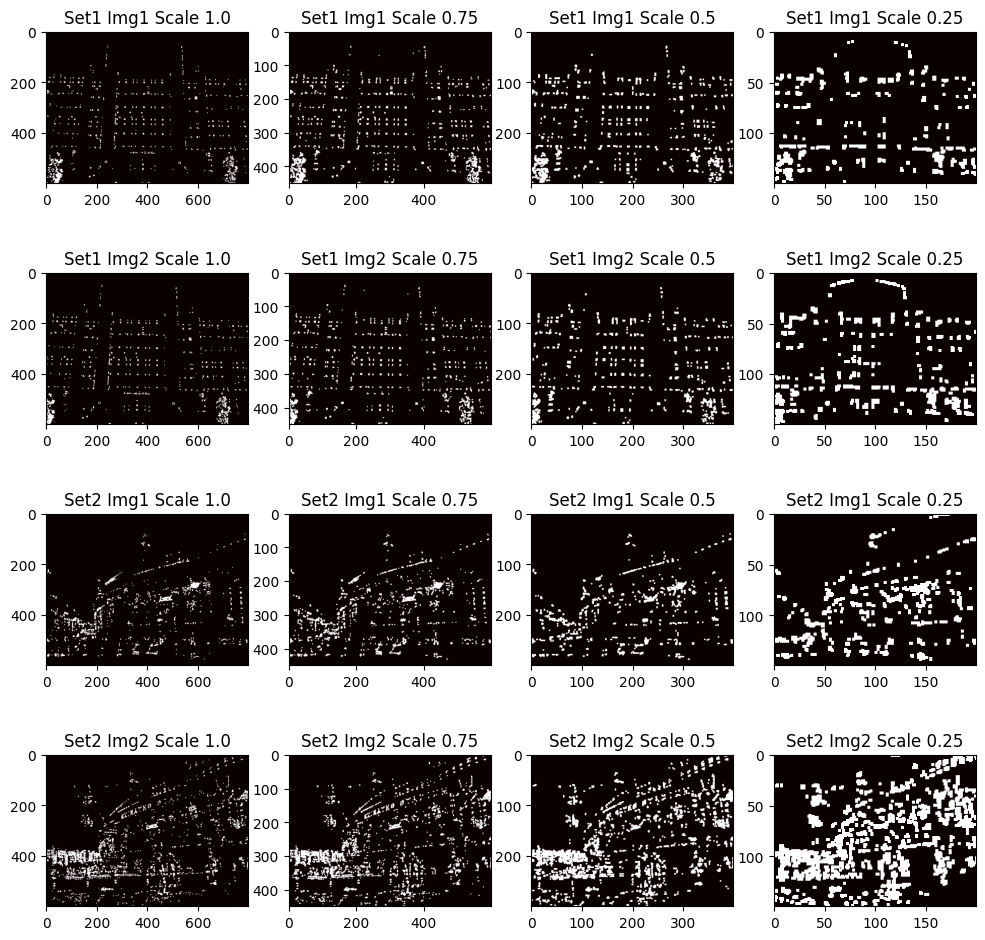

In [ ]:
# Display Harris corner results
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
image_titles = ["Set1 Img1", "Set1 Img2", "Set2 Img1", "Set2 Img2"]

for i, key in enumerate(harris_results.keys()):
    for j, scale in enumerate(scales):
        axs[i, j].imshow(harris_results[key][j], cmap='hot')
        axs[i, j].set_title(f'{image_titles[i]} Scale {scale}')
plt.show()

####**Using SSD matrics to establish correspondences between the interest points in the two images of the same scene.**

In [ ]:
# SSD Matching
def ssd_match(img1, img2, corners1, corners2):
    matches = []
    for y1, x1 in np.argwhere(corners1):
        min_dist = float('inf')
        best_match = None
        for y2, x2 in np.argwhere(corners2):
            patch1 = img1[y1-2:y1+3, x1-2:x1+3]
            patch2 = img2[y2-2:y2+3, x2-2:x2+3]
            if patch1.shape == patch2.shape:
                dist = np.sum((patch1 - patch2) ** 2)
                if dist < min_dist:
                    min_dist = dist
                    best_match = (x2, y2)
        if best_match:
            matches.append(((x1, y1), best_match))
    return matches

####**Visualize matches**

In [ ]:
matches_set1 = ssd_match(gray1_set1, gray2_set1, harris_results["set1_img1"][0], harris_results["set1_img2"][0])
matches_set2 = ssd_match(gray1_set2, gray2_set2, harris_results["set2_img1"][0], harris_results["set2_img2"][0])

def draw_matches(img1, img2, matches, title):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    combined_img = np.hstack((img1, img2))
    ax.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))

    for (x1, y1), (x2, y2) in matches:
        ax.plot([x1, x2 + img1.shape[1]], [y1, y2], 'r-')

    plt.title(title)
    plt.show()

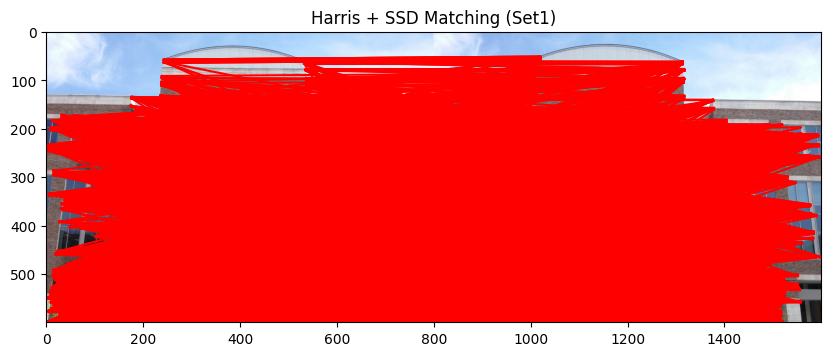

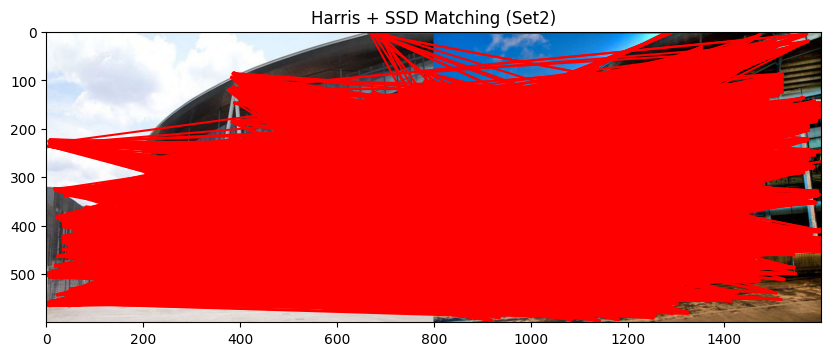

In [ ]:
# Display SSD Matching results
draw_matches(img1_set1, img2_set1, matches_set1, "Harris + SSD Matching (Set1)")
draw_matches(img1_set2, img2_set2, matches_set2, "Harris + SSD Matching (Set2)")

####**SIFT Feature Matching**

In [ ]:
sift = cv2.SIFT_create()

def sift_matching(img1, img2, title):
    kp1, des1 = sift.detectAndCompute(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), None)
    kp2, des2 = sift.detectAndCompute(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    sift_matched_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.figure(figsize=(10, 5))
    plt.imshow(sift_matched_img)
    plt.title(title)
    plt.show()

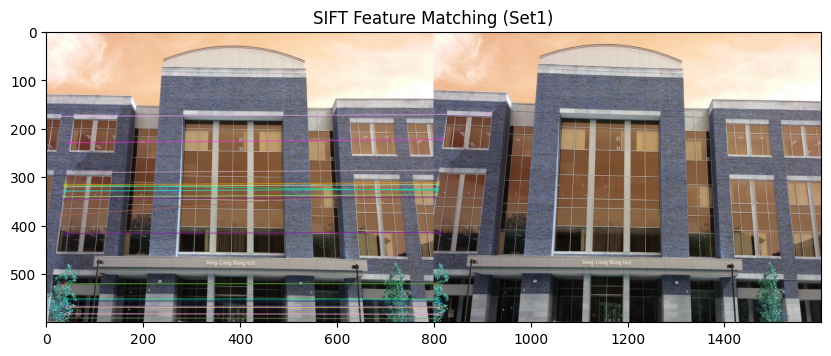

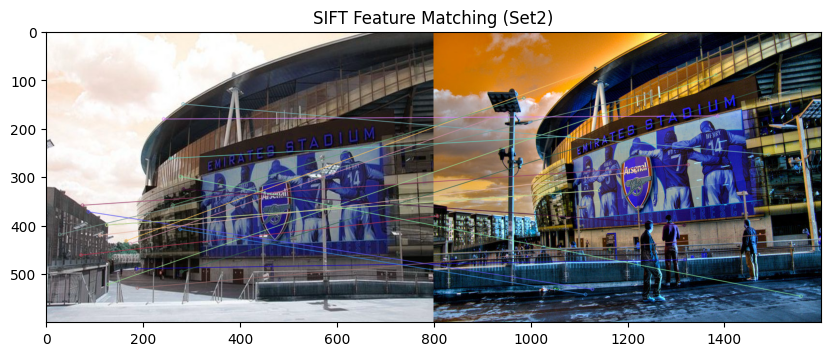

In [ ]:
# Apply SIFT matching to both sets
sift_matching(img1_set1, img2_set1, "SIFT Feature Matching (Set1)")
sift_matching(img1_set2, img2_set2, "SIFT Feature Matching (Set2)")

###**Comparison of Quality of Correspondence**

####**1. Harris + SSD Matching**

*   The matching results are heavily cluttered with red lines, indicating a large number of correspondences.
*   Many of these correspondences seem to be incorrect or misaligned, suggesting a high false positive rate.

*   The lack of orientation and scale invariance in Harris corners makes the feature matching sensitive to variations in viewpoint and lighting.
*   SSD, being a simple pixel-wise comparison method, is highly susceptible to mismatches in cases of illumination changes and perspective distortions.

####**2. SIFT Feature Matching**

*   The SIFT-based matching appears to produce much more accurate and meaningful correspondences.
*   The matches are more structured and aligned with key features in the images.

*   SIFT is scale and rotation invariant, making it more robust to changes in viewpoint and lighting conditions.
*   The number of false matches seems significantly lower compared to Harris + SSD.

**SIFT clearly outperforms Harris + SSD in feature matching quality.**